### Thinking

Kevin Murphy: 12 (PPCA) and 16 

# Problem statement: finding best pricing model for classical historical VaR

First consider a simple problem where there are only prices and time labels (all other features such as maturity date, type etc are constant). I think this simplifies the notation/presentation.

Consider some observables $X_t \in \mathbb{R}^n$ and parameters $\theta_t \in \mathbb{R}^m, \; m < n$ and and $F$ taking one to the other up to some noise

$$
X_t = F(\theta_t) + \epsilon_t, \; t=T, T-1, ..., T-K.
$$

So given an $F$, $\theta$ are determined as point-estimates that best fit the $X$ in some canonical way. $\theta$ is not allowed to have any "memory" in this simple approach (i.e. no latent rolling features etc). There really is no interaction between the time slices. This will seem even more bizarre in what follows.

We probably want to find nice $F$s such that the time series of "innovations" or "scenarios"

$$
\text{d}\theta_t = \theta_{t+1} - \theta_t
$$

are "as stationary as possible" (i.e. under some empirical measure of stationarity) and we care much more about spatial stationarity than trying to capture any perceived temporal non-stationarity (does this statement make sense?). 

Additionally, we will then be forced to model the distribution of future values 1-day in the future using an historical bootstrap of the daily changes in $\theta$:

$$
X_{t+1} \sim \text{Emp}(F(\theta_t + \text{d} \theta_s), \; s=T-1,T-2,...,T-K)
$$

Furthermore, let's say what we really care about are linear combinations of $X$ (i.e. portfolios of $X$). Let $\mathcal{L}_t(\alpha, F)$ be the Likelihood of the value of an $\alpha$-portfolio $\alpha^T X_{t+1}$ under the empirical measure $\text{Emp}_t(F)$.

We will want to find optimal $F$ for either a) all possible $\alpha$ or b) simply for a given $\alpha$. For the former, we might choose a cost function something like

$$
\text{min}_{\alpha, |\alpha|>0}\sum_t \log \mathcal{L}_t(\alpha, F) 
$$

where I would have to think a bit deeper about the constraint on $\alpha$. I think $\alpha$ basically scales out and can be simplified somehow.

## Can we separate the problem into two or more smaller problems?

$$
Y = G(X) + \epsilon
$$

1. Best predictive mode, pick a $G$ to get $\epsilon$ small
1. Best explanatory model, given $\epsilon$ pick smallest $G$


# Example data

## CL rolled futures

Rolling will introduce some weirdness but will simplify data representation. Can think about better structure for dated historical contracts later.

## FRED swaps

Probably a better place to start that CL futures.

In [9]:
import Quandl
import os
import pandas

# plz not abuse, you can get your own token for free
cottrdav_authtoken = "GMs5ZwtAzsTP6MAHoyCH"

def get_data(storefile=None, storekey=None, tickers=None):
    if not os.path.exists(storefile):
        print("getting data from quandl")
        d = dict()
        for ticker in tickers:
            d[ticker] = Quandl.get(ticker, authtoken=cottrdav_authtoken)
            print(ticker, d[ticker].shape)
        df = pandas.Panel(d)
        print('saving to %s.%s' % (storefile, storekey))
        df.to_hdf(storefile, storekey)
    else:
        print('reading %s.%s' % (storefile, storekey))
        df = pandas.read_hdf(storefile, storekey)
    print('shape is %s' % (df.shape,))
    return(df)

def get_cl_data():
    tickers = ['SCF/CME_CL%d_FW' % i for i in range(1, 10)]
    storefile='CME_CL_FW.h5'
    storekey='data'
    return(get_data(**locals()))
    
def get_swap_data():
    tickers = ['FRED/DSWP%d' % i for i in [1, 2, 3, 5, 7, 10]]
    storefile='FRED_DSWP.h5'
    storekey='data'
    return(get_data(**locals()))    

data_cl = get_cl_data()
data_swaps = get_swap_data()

reading CME_CL_FW.h5.data
shape is (9, 8015, 6)
reading FRED_DSWP.h5.data
shape is (6, 3666, 1)


Populating the interactive namespace from numpy and matplotlib


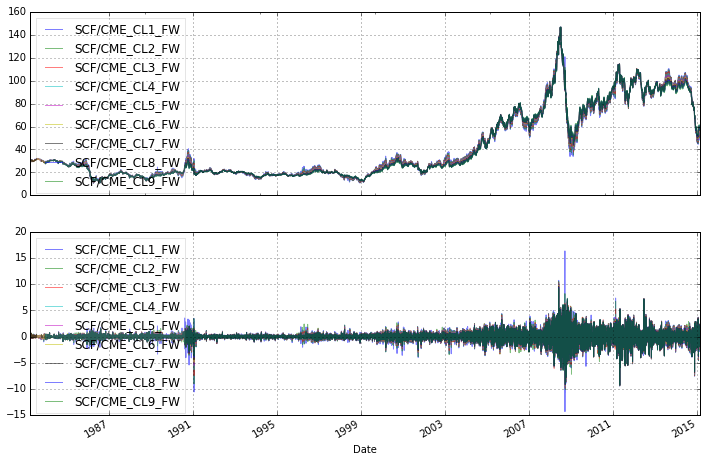

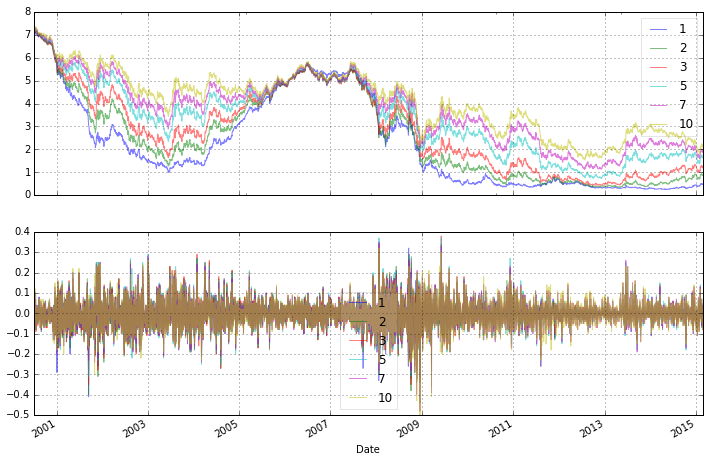

In [18]:
%pylab inline

def do_plot(df):
    figure(figsize=(12, 8))
    ax = subplot(211)
    p = df.plot(ax=ax, alpha=0.5)
    gca().get_legend().get_frame().set_alpha(.1)
    ax = subplot(212)
    p = df.diff().plot(ax=ax, alpha=0.5)
    gca().get_legend().get_frame().set_alpha(.1)
    
df = data_cl.loc[:,:,'Settle']
do_plot(df)

df = data_swaps.loc[:,:,'Value']
df.columns = [int(x.split('DSWP')[-1]) for x in df.columns]
df = df.sort_index(axis=1)
do_plot(df)
